In [71]:
import numpy as np
import math
import matplotlib.pyplot as plt

%matplotlib inline  

In [65]:
Xtrain_file = 'data/Xtrain.csv'
Ytrain_file = 'data/Ytrain.csv'

# load training files 
X_train = np.genfromtxt(Xtrain_file, delimiter=',').astype(int)
Y_train = np.genfromtxt(Ytrain_file, delimiter=',').astype(int)


# create 90-10 split for testing
X_test = X_train[-50:]
Y_test = Y_train[-50:]

X_train = X_train[:5]
Y_train = Y_train[:5]

In [66]:
# Naive Bayes
model = NB_Classifier()
model.fit(X_train, Y_train)
nb_results = model.predict(X_test)

In [67]:
print(accuracy_score(nb_results, Y_test))

0.78


In [68]:
# Voted Perceptron @ 10 epochs
Y_trainVP = Y_train[:]
Y_trainVP[Y_trainVP == 0] = -1

model = VP_Classifier()
model.fit(X_train, Y_trainVP)
vp_results = model.predict(X_test)

In [69]:
from sklearn.metrics import accuracy_score

print(accuracy_score(vp_results, Y_test))
print(accuracy_score(nb_results, Y_test))

## % 90
# VP = 1.0
# NB = 1.0
## %20
# VP = .94
# NB = .78
## %10
# VP = .92
# NB = .96
## %5
# VP = .94
# NB = .80
## %2
# VP = .82
# NB = .78
## %1
# VP = .76
# NB = .78

0.76
0.78


/Users/abhishekbhattacharya/anaconda/lib/python2.7/site-packages/matplotlib/legend.py:633: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x112cb5890>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
/Users/abhishekbhattacharya/anaconda/lib/python2.7/site-packages/matplotlib/legend.py:633: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x112a04190>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)


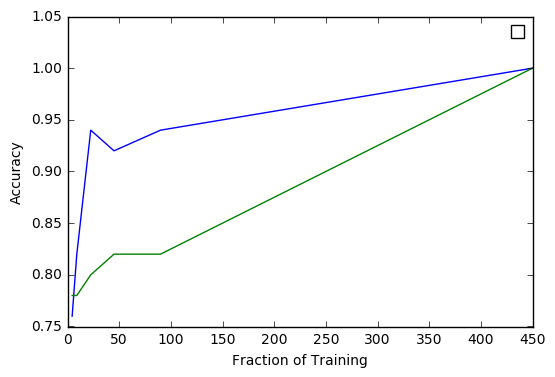

In [77]:
vp_acc = [.76, .82, .94, .92, .94, 1.0]
nb_acc = [.78, .78, .80, .82, .82, 1.0]
frac = [.01*450, .02*450, .05*450, .10*450, .20*450, 450]



vp = plt.plot(frac, vp_acc, label='Voted Perceptron')
nb = plt.plot(frac, nb_acc,label='Naive Bayes')
plt.legend([vp, nb], ['Voted Perceptron', 'Naive Bayes'])


# plt.plot(frac, vp_acc, frac, nb_acc)
plt.xlabel("Fraction of Training")
plt.ylabel('Accuracy')
plt.show()

In [5]:
class NB_Classifier:
    """ Simple Naive Bayes Classifier """

    def fit(self, X, y):
        """ Train NB classifier  """
        # train set size
        self.train_size = float(len(y))

        # number of instances per class
        self.class_0, self.class_1 = np.bincount(y)

        # log priors
        self.log_class_0_prior = math.log(self.class_0 / self.train_size)
        self.log_class_1_prior = math.log(self.class_1 / self.train_size)

        # total vocabulary
        self.V = len(X[0])

        # total tokens in each class (scalar)
        self.class_0_wtot = 0 + self.V*0.5 # add one-smoothing of 0.5
        self.class_1_wtot = 0 + self.V*0.5 # add one-smoothing

        # total per token in each class (vector)
        self.class_0_vectot = np.full(len(X[0]), 0.5) # ones == add one-smoothing
        self.class_1_vectot = np.full(len(X[0]), 0.5)

        self.loglike_0_vec = np.zeros(len(X[0]), dtype=np.int)
        self.loglike_1_vec = np.zeros(len(X[0]), dtype=np.int)

        # sum of the total tokens
        for x, y in zip(X, y):
            if y == 0:
                self.class_0_wtot += np.sum(x)
                self.class_0_vectot += x
            else:
                self.class_1_wtot += np.sum(x)
                self.class_1_vectot += x

        for i in range(self.V):
            self.loglike_0_vec[i] = math.log(self.class_0_vectot[i]/float(self.class_0_wtot))
            self.loglike_1_vec[i] = math.log(self.class_1_vectot[i]/float(self.class_1_wtot))

    def predict(self, X):
        """ Takes vector of samples and returns predictions """
        preds = []
        sum_0 = self.log_class_0_prior
        sum_1 = self.log_class_1_prior

        for i, x in enumerate(X):
            for idx, val in enumerate(x):
                if val != 0:
                    sum_0 += (self.loglike_0_vec[idx]*val)
                    sum_1 += (self.loglike_1_vec[idx]*val)


            preds.append(np.argmax([sum_0, sum_1]))
            sum_0 = self.log_class_0_prior
            sum_1 = self.log_class_1_prior

        return preds


class VP_Classifier:
    """ Voted Perceptron Classifier """

    def fit(self, X, labels):
        """ Train Voted Perceptron  """
        # Init variables
        self.c = np.zeros(1)
        self.w = np.zeros((1, len(X[0])))

        e = 10 # epochs
        y_hat = 0
        k = 0

        for _ in range(e):
            for idx, (x, y) in enumerate(zip(X, labels)):
                y_hat = int(np.sign(np.dot(self.w[k], x)))

                if y_hat == y:
                    self.c[k] += 1
                else:
                    self.w = np.append(self.w, [self.w[k] + y*x], axis=0)
                    self.c = np.append(self.c, [1])
                    k += 1


    def predict(self, X):
        """ Takes vector of samples and returns predictions """
        preds = []
        y_hat = 0

        for x_test in X:
            for i in range(len(self.c)):
                y_hat += self.c[i] * np.sign(np.dot(self.w[i], x_test))

            if int(np.sign(y_hat)) == -1:
                preds.append(0)
            else:
                preds.append(1)
            y_hat = 0

        return preds